# Combining Different Models for Ensemble Learning

In the previous chapter, we focused on the best practices for tuning and evaluating different models for classification. In this chapter, we will build upon these techniques and explore different methods for constructing a set of classifiers that can often have a better predictive performance than any of its individual members. We will learn how to do the following:

* Make predictions based on majority voting
* Use bagging to reduce overfitting by drawing random combinations of the training set with repetition
* Apply boosting to build powerful models from *weak learners* that learn from their mistakes

# Learning with ensembles

The goal of **ensemble methods** is to combine different classifiers into a meta-classifier that has better generalization performance than each individual classifier alone. For example, assuming that we collected predictions from 10 experts, ensemble methods would allow us to strategically combine these predictions by the 10 experts to come up with a prediction that is more accurate and robust than the predictions bt each individual expert. As we will see later in this chapter, there are several different approaches for creating an ensemble of classifiers. In this section, we will introduce a basic perception of how ensembles work and why they are typically recognized for yielding a good generalization performance. 

In this chapter, we will focus on the most popular ensemble method that use the **majority voting** principle. Majority voting simply means that we select the class label that has been predicted by the majority of classifiers, that is, received more than 50 percent of the votes. Strictly speaking, the term **majority vote** refers to binary class settings only. However, it is easy to generalize the majority voting principle to multi-class settings, which is called **plurality voting**. Here, we select the class label that received the most votes (mode). The following diagram illustrates the concept of majority and plurality voting for an ensemble of 10 classifiers where each unique symbol (triangle, square and circle) represents a unique class label:

<img src='images/07_01.png'>

Using the training set, we start by training *m* different classifiers ($C_1, \ldots, C_m$). Depending on the technique, the ensemble can be built from different classification algorithms, for example, decision trees, suport vector machines, logistic regression classifiers, and so on. Alternatively, we can also use the same class classification algorithm, fitting different subsets of the training set. One prominent example of this approach is the random forest algorithm, which combines different decision tree classifiers. The following figure illustrates the concept of a general ensemble approach using majority voting: 

<img src='images/07_02.png'>

To predict a class label via simple majority or plurality voting, we combine the predicted class labels of each individual classifier and select the class label that received the most votes. 

To illustrate why ensemble methods can work betten than individual classifiers alone, let's apply the simple concepts of combinatorics. For the following example, we make the assumption that all $n$-base classifiers for a binary classification task have an equal error rate $\epsilon$. Furthermore, we assume that the classifiers are independent and the error rates are not correlated. Under those assumptions, we can simply express the error probability of an ensemble of base classifiers as a probability mass function of a binomial distribution:

$$P(y \ge k) = \sum_k^n {n \choose k} \epsilon^k (1 - 0.25)^{n-k} = \epsilon_{ensemble}$$

Here, ${n \choose k}$ is the binomial coefficient **n choose k**. In other words, we compute the probability that the prediction of the ensemble is wrong. Now let's take a look at a more concrete example of 11 base classifiers ($n = 11$), where each classifier has an error rate of 0.25 ($\epsilon = 0.25$):

$$P(y \ge k) = \sum_{k=6}^{11} {11 \choose k} 0.25^k (1 - \epsilon)^{11-k} = 0.034$$

As we can see, the error rate of ensemble (0.034) is much lower than the error rate of each individual classifier (0.25) if all the assumptions are met. Note that, in this simplified illustration, a 50-50 split by an even number of classifiers $n$ is treated as an error, whereas this is only true half of time. To compare such an idealistic ensemble classifier to a base classifier over a range of different base error rates, let's implement the probability mass function in Python: 

In [1]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.0))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k) for k in range(k_start, n_classifier + 1)]
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

After we have implemented the *ensemble_error* function, we can compute the ensemble error rates for a range of different base errors from 0.0 to 1.0 to visualize the relationship between ensemble and base errors in a line graph: 

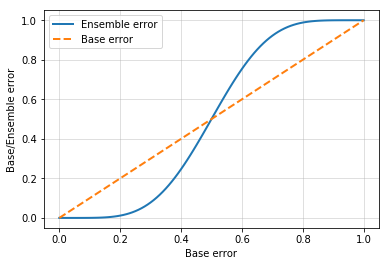

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]
plt.plot(error_range, ens_errors, label='Ensemble error', 
         linewidth=2)
plt.plot(error_range, error_range, linestyle='--', 
         label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

As we can see in the resulting plot, the error probability of an ensemble is always better than the error of an individual base classifier, as long as the base classifiers perform betten than random guessing ($\epsilon < 0.5$). Note that the $y$-axis depicts the base error (dotted line) as well as the ensemble error (continuous line). 

## Combining classifiers via majority vote

After the short introduction to ensemble learning in the previous section, let's start with a warm-up exercise and implement a simple ensemble classifier for majority voting in Python. 

Although the majority voting algorithm that we will discuss in this section also generalizes to multi-class settings via plurarity voting, we will use the term majority voting for simplicity, as it is also often done in the literature. 

## Implementing a simple majority vote classifier

The algorithm we we are going ot implement in this section will allow us to combine different classification algorithms associated with individual weights for confidence. Our goal is to build a stronger meta-classifier that balances out the individual classifiers's weaknesses on a particular dataset. 

To translate the concept of the weighted majority vote into Python, we can use NumPy's convenient *argmax* and *bincount* functions:

In [4]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

As we remember from the discussion on logistic regression, certain classifiers in scikit-learn can also return the probability of a predicted class label via the *predict_proba* method. Using the predicted class probabilities instead of the class labels for majority voting can be useful if the classifiers in our ensemble are well calibrated. 

To implement the weighted majority vote based on class probabilities, we can again make use of NumPy using *numpy.average* and *np.argmax*: 

In [5]:
ex = np.array([[0.9, 0.1], 
               [0.8, 0.2], 
               [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])  
p

array([0.58, 0.42])

Putting everything together, let's new implement *MajorityVoteClassifier* in Python: 

In [12]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ A majority vote ensemble classifier
    
    Parameters
    --------------
    classifiers : array-like, shape = [n_classifiers]
        Different classifiers for the ensemble
    
    vote : str, {'classlabel', 'probability'}
        Default: 'classlabel'
        If 'classlabel' the prediction is based on 
        the argmax of class labels. Else if 
        'probability', the argmax of the sum of the 
        probabilities is used to predict the class label 
        (recommended for calibrated classifiers). 
        
    weights : array-like, shape = [n_classifiers]
        Optional, default: None
        If a list of 'int' or 'float' values are provided, 
        the classifiers are weighted by importance; 
        Uses uniform weights if 'weights=None'. 
    """
    
    def __init__(self, classifiers, vote='classlabel', 
                 weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in 
                                  _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """ Fit classifiers.
        
        Parameters
        --------------
        X : {array-like, sparse matrix}, 
            shape = [n_samples, n_features]
            Matrix of training samples. 
        y : array-like, shape = [n_samples]
            Vector of target class labels.
            
        Returns
        --------------
        self : object 
        """
        
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc__ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """ Predict class labels for X.
        
        Parameters
        --------------
        X : {array-like, sparse matrix}, 
            Shape = [n_samples, n_features]
            Matrix of training samples. 
            
        Returns
        --------------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
        """
        
        if self.vote == 'probability':
            maj_vote= np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel' vote
            # Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) 
                                      for clf in 
                                      self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x:
                                           np.argmax(np.bincount(x), 
                                                     weights=self.weights), 
                                           axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """ Predict class probabilities for X.
        
        Parameters
        --------------
        X : {array-like, sparse matrix}, 
            shape = [n_samples, n_features]
            Training vectors, where n_samples is 
            the number of samples and n_features is the 
            number of features. 

        Returns
        --------------
        avg_proba : array-like, 
            shape = [n_samples, n_classes]
            Weighted average probability for 
            each class per sample. 
        """
        
        probas = np.array([clf.predict_proba(X)
                           for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch
        """
        
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

Also, note that we defined our own modified version of the *get_params* method to use the *_name_estimators* function to access the paramters of individual classifiers in the ensemble; this may look a little bit complicated at first, but it will make perfect sense when we use grid search for hyperparameter tuning in later sections. 

## Using the majority voting principle to make predictions

Now it is about time to put the *MajorityVoteClassifier* that we implemented into action. But first, let's prepare a dataset that we can test it on. Since we are already familiar with techniques to load datasets from CSV files, we will take a shortcut and load the Iris dataset from scikit-learn's dataset module. Furthermore, we will only select two features, **sepal width** and **petal length**, to make the classification task more challenging for illustration purposes. Although our *MajorityVoteClassifier* generalizes to multiclass problems, we will only classify flower samples from the *Iris-versicolor* and *Iris-virginica* classes, with which we will compute the ROC AUC later. The code is as follows: 

In [15]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

Next, we split the Iris samples into 50 percent training and 50 percent test data:

In [16]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, 
                     random_state=1, stratify=y)

Using the training dataset, we now will train three different classifiers:
* Logistic regression classifier
* Decision tree classifier
* k-nearest neighbors classifier

We then evaluate the model performance of each classifier via 10-fold cross-validation on the training dataset before we combine them into an ensemble classifier: 

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], 
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], 
                  ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3] , clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, 
                             y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]'
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


Now let's move on to the more exciting part and combine the individual classifiers for majority rule voting in our *MajorityVoteClassifier*: 

In [ ]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, y=y_train, 
                             cv=10, scoring='roc_auc')
    print('Accuracy: %0.2f (+/- %0.2f) [%s]'
          %)